CST output is $\tilde{E}$ and $\tilde{H}$ specified over a 2D sheet.

Construct $\tilde{S}=\tilde{E}\times\tilde{H}$.

Then take radial average of $|\tilde{S}|=\sqrt{\tilde{S}\tilde{S}^*}$.

Then convert to dB.

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log10
c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log10


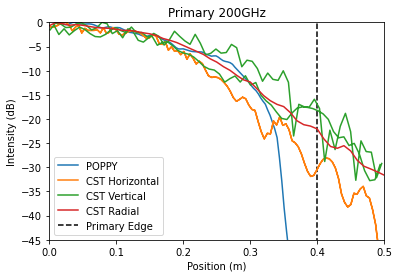

<Figure size 432x288 with 0 Axes>

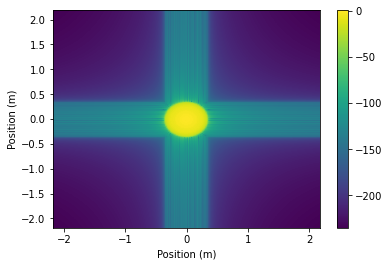

In [12]:
# From lens to primary... @ 50GHz, 100GHz, 200GHz, or ...
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from astropy.units import cds

simfreq = 200 # Select: 50, 100, or 200

if simfreq == 50:
    ff = 50 * u.GHz
    CST_hcut=np.loadtxt(open("EXCLAIM_Data/US_Full/50GHz_r35_vcut.txt", "r"), delimiter=",")
    CST_hcut_x=np.loadtxt(open("EXCLAIM_Data/US_Full/50GHz_r35_vcut_z.txt", "r"), delimiter=",")
    CST_vcut=np.loadtxt(open("EXCLAIM_Data/US_Full/50GHz_r35_hcut.txt", "r"), delimiter=",")
    CST_vcut_z=np.loadtxt(open("EXCLAIM_Data/US_Full/50GHz_r35_hcut_x.txt", "r"), delimiter=",")
    CST_rad=np.loadtxt(open("EXCLAIM_Data/US_Full/50GHz_r35_radial.txt", "r"), delimiter=",")
elif simfreq == 100:    
    ff = 100 * u.GHz
    CST_hcut=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_vcut.txt", "r"), delimiter=",")
    CST_hcut_x=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_vcut_z.txt", "r"), delimiter=",")
    CST_vcut=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_hcut.txt", "r"), delimiter=",")
    CST_vcut_z=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_hcut_x.txt", "r"), delimiter=",")
    CST_rad=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_radial.txt", "r"), delimiter=",")
elif simfreq == 200:    
    ff = 200 * u.GHz
    CST_hcut=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_vcut.txt", "r"), delimiter=",")
    CST_hcut_x=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_vcut_z.txt", "r"), delimiter=",")
    CST_vcut=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_hcut.txt", "r"), delimiter=",")
    CST_vcut_z=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_hcut_x.txt", "r"), delimiter=",")
    CST_rad=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_radial.txt", "r"), delimiter=",")


# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

# Aperatures
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)
coldstop = poppy.CircularAperture(radius=0.05*u.m)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
width=0.5*u.cm

ll = const.c/ff

wf = poppy.FresnelWavefront(beam_radius=20*u.cm, wavelength=ll) # 8.13 from Trevor?


    
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
wf *= lenslet_aperture

wf *= coldstop

wf.propagate_fresnel(0.35*u.cm)
        
for i,baffle_z in enumerate(baffle_z_array):
    if i==0:
        wf.propagate_fresnel(baffle_z)
    else:
        wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
    wf*=baffle

wf.propagate_fresnel(d_lens_3 - baffle_z_array[-1]) # propogate to center of tertiary

wf *= tertiary_obj
    
#wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
   
#wf *= secondary_obj
    
#wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
     
wf.propagate_fresnel(d_2_1 + d_3_2) # propogate from teriary to primary
    
y, x = wf.coordinates()
plt.figure(3)
plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label="POPPY")
CST_hcut=10*np.log10(CST_hcut/np.max(CST_hcut))
idxh = np.argsort(CST_hcut_x)
plt.plot(np.abs(CST_hcut_x[idxh])/100,CST_hcut[idxh],label='CST Horizontal')
CST_vcut=10*np.log10(CST_vcut/np.max(CST_vcut))
idxv = np.argsort(CST_vcut_z)
plt.plot(np.abs(CST_vcut_z[idxv])/100,CST_vcut[idxv],label='CST Vertical')
plt.plot(np.linspace(0,0.50,51),CST_rad,label='CST Radial')
    
plt.vlines(0.4,ymin=-100,ymax=0,linestyles='dashed',label="Primary Edge")
plt.legend()
plt.xlim([0,0.5])
plt.ylim([-45,0])
plt.title("Primary "+str(simfreq)+"GHz")
plt.xlabel("Position (m)")
plt.ylabel("Intensity (dB)")
plt.savefig("Primary_Ill_"+str(simfreq)+"GHz.png")
plt.show()
plt.clf()

a=400 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log10
c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log10


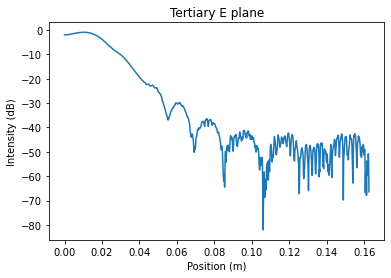

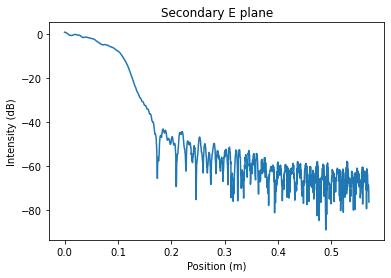

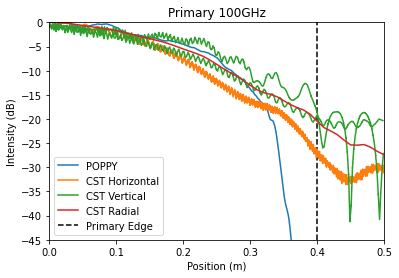

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

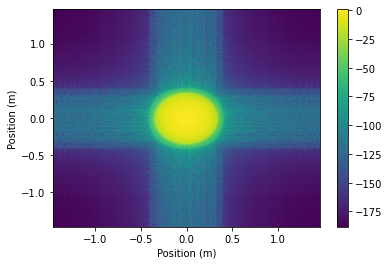

In [1]:
# From lens to primary... @ 100GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from astropy.units import cds

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

# Aperatures
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)
coldstop = poppy.CircularAperture(radius=0.05*u.m)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 100 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=8.13*u.cm, wavelength=ll) #8.13 taken from Trevor

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    wf *= coldstop

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3 - baffle_z_array[-1]) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    #wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label="POPPY")
    CST_hcut=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_vcut.txt", "r"), delimiter=",")
    CST_hcut=10*np.log10(CST_hcut/np.max(CST_hcut))
    CST_hcut_x=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_vcut_z.txt", "r"), delimiter=",")
    idxh = np.argsort(CST_hcut_x)
    plt.plot(np.abs(CST_hcut_x[idxh])/100,CST_hcut[idxh],label='CST Horizontal')
    #plt.scatter(np.abs(CST_hcut_x)/100,CST_hcut,label='CST Horizontal',s=0.1,c="r")
    CST_vcut=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_hcut.txt", "r"), delimiter=",")
    CST_vcut=10*np.log10(CST_vcut/np.max(CST_vcut))
    CST_vcut_z=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_hcut_x.txt", "r"), delimiter=",")
    idxv = np.argsort(CST_vcut_z)
    plt.plot(np.abs(CST_vcut_z[idxv])/100,CST_vcut[idxv],label='CST Vertical')
    #plt.scatter(np.abs(CST_vcut_z)/100,CST_vcut,label='CST Vertical',s=0.1,c="g")
    CST_rad=np.loadtxt(open("EXCLAIM_Data/US_Full/100GHz_CHTCr27_radial.txt", "r"), delimiter=",")
    plt.plot(np.linspace(0,0.50,51),CST_rad,label='CST Radial')
    
    
    plt.vlines(0.4,ymin=-45,ymax=0,linestyles='dashed',label="Primary Edge")
    plt.legend()
    plt.xlim([0,0.5])
    plt.ylim([-45,0])
    plt.title("Primary 100GHz")
    
    
for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log10
c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log10


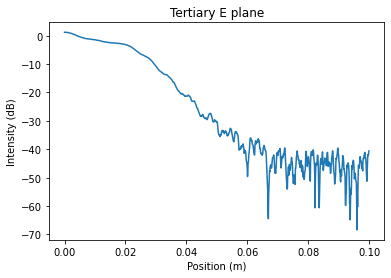

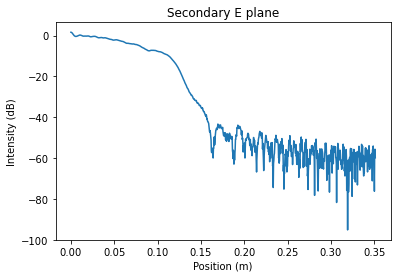

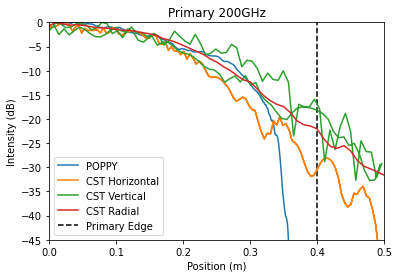

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

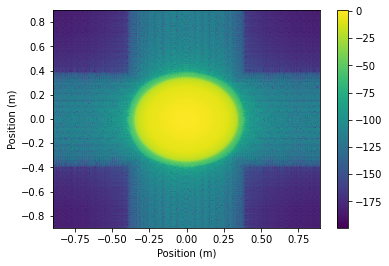

In [1]:
# From lens to primary... @ 200GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from astropy.units import cds

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

# Aperatures
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)
coldstop = poppy.CircularAperture(radius=0.05*u.m)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 200 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    wf *= coldstop

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3 - baffle_z_array[-1]) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    #wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label='POPPY')
    CST_hcut=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_vcut.txt", "r"), delimiter=",")
    CST_hcut=10*np.log10(CST_hcut/np.max(CST_hcut))
    CST_hcut_x=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_vcut_z.txt", "r"), delimiter=",")
    idxh = np.argsort(CST_hcut_x)
    plt.plot(np.abs(CST_hcut_x[idxh])/100,CST_hcut[idxh],label='CST Horizontal')
    #plt.scatter(np.abs(CST_hcut_x)/100,CST_hcut,label='CST Horizontal',s=0.5,c="r")
    CST_vcut=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_hcut.txt", "r"), delimiter=",")
    CST_vcut=10*np.log10(CST_vcut/np.max(CST_vcut))
    CST_vcut_z=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_hcut_x.txt", "r"), delimiter=",")
    idxv = np.argsort(CST_vcut_z)
    plt.plot(np.abs(CST_vcut_z[idxv])/100,CST_vcut[idxv],label='CST Vertical')
    #plt.scatter(np.abs(CST_vcut_z)/100,CST_vcut,label='CST Vertical',s=0.5,c="g")
    CST_rad=np.loadtxt(open("EXCLAIM_Data/US_Full/200GHz_CHTCr30_radial.txt", "r"), delimiter=",")
    plt.plot(np.linspace(0,0.50,51),CST_rad,label='CST Radial')
    
    
    plt.vlines(0.4,ymin=-45,ymax=0,linestyles='dashed',label="Primary Edge")
    plt.legend()
    plt.xlim([0,0.5])
    plt.ylim([-45,0])
    plt.title("Primary 200GHz")
    
for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

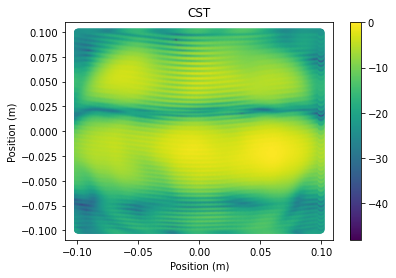

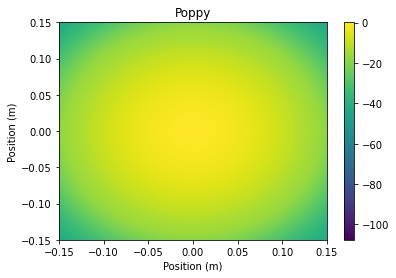

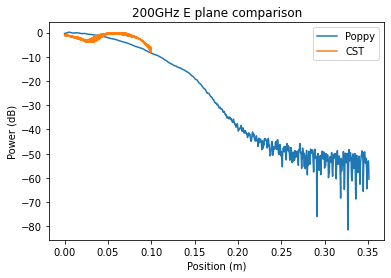

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


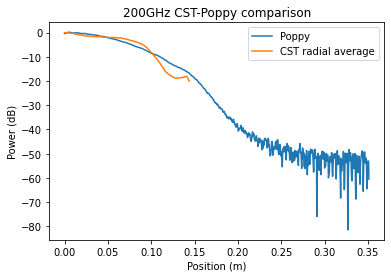

In [2]:
import math
#run13 is 100GHz and run18 is 200GHz
xpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run18/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run18/zpos.txt')
power=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run18/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100

fig, ax = plt.subplots()
scaling=10*np.log10(power)-max(10*np.log10(power))
c=ax.scatter(xpos,zpos,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.savefig("CST_200GHz.png")
plt.show()

plt.pcolormesh(x2,y2,10*np.log10(pop_power))
#plt.scatter(x2,y2,10*np.log10(pop_power))
plt.colorbar()
plt.title('Poppy')
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.savefig("Poppy_200GHz.png")
plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
count=0
zmin=min(abs(zpos))+0.001
for it in np.arange(0,len(xpos)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
        
plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(Epos,Epow-Epowmax,label='CST')
plt.title('200GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
#plt.savefig("Eplane_200GHz_comparison.png")
plt.show()

radii=np.linspace(0,0.15)
radialpow=np.zeros_like(radii)
radialnorm=np.zeros_like(radii)
for it in np.arange(0,len(xpos)):
    #done=False
    #rit=1
    r=np.sqrt(xpos[it]**2+zpos[it]**2)
    idx=int(math.floor(r*50/0.15))
    if idx < 50:    
        radialpow[idx] += power[it]
        radialnorm[idx] += 1
    #while done==False:
    #    if r <radii[rit]:
    #        radialpow += power[it]
    #        radialnorm += 1
    #        done==True
    #    elif rit==49: #number of it s in linspace less one
    #        done==True
    #    else:
    #        rit +=1
    
            
for it in np.arange(0,len(radii)):
    radialpow[it]=radialpow[it]/radialnorm[it] # convert from total to mean power

maxrpow=max(10*np.log10(radialpow))    
radialpow=10*np.log10(radialpow)-maxrpow # convert to normalized dB

plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(radii,radialpow,label='CST radial average')
plt.title('200GHz CST-Poppy comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
#plt.savefig("Eplane_RadialAverage_200GHz_comparison.png")
plt.show()            
        

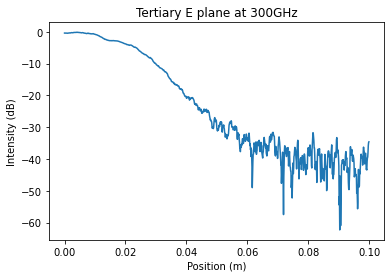

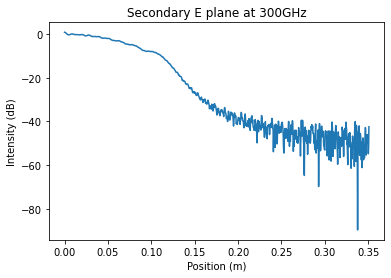

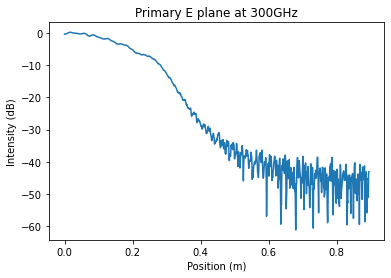

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

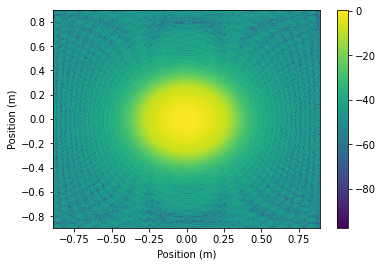

In [1]:
# From lens to primary... @ 300GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 300 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane at 300GHz")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    ring = poppy.CircularAperture(radius=0.0381*u.m)
    wf *= ring # cold stop

    wf.propagate_fresnel(d_lens_3) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))

for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

(164171,)
(164171,)
(164171,)


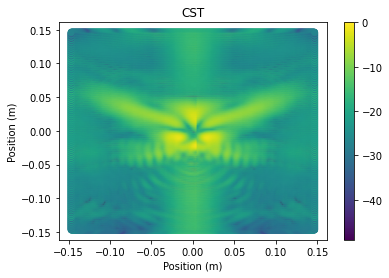

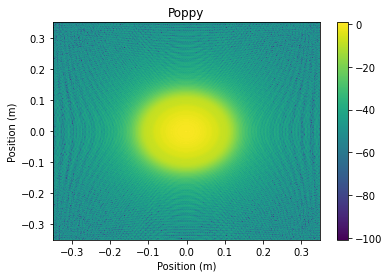

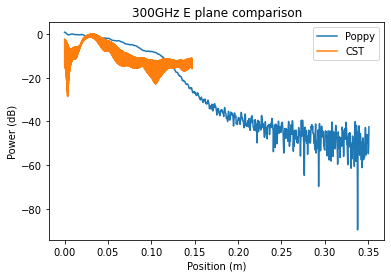

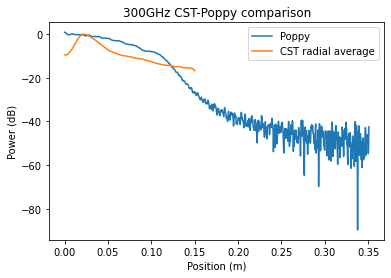

In [8]:
# 300GHz comparison continued
import math
xpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run8.2/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run8.2/zpos.txt')
power=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run8.2/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100

fig, ax = plt.subplots()
scaling=10*np.log10(power)-max(10*np.log10(power))
scaling=np.concatenate((scaling, scaling), axis=0) #This will serve to mirror the CST field monitor over the plane of symmetry
xp=np.concatenate((xpos, -xpos), axis=0)
zp=np.concatenate((zpos, zpos), axis=0)
c=ax.scatter(xp,zp,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()


plt.pcolormesh(x2,y2,10*np.log10(pop_power))
#plt.scatter(x2,y2,10*np.log10(pop_power))
plt.colorbar()
plt.title('Poppy')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
count=0
zmin=min(abs(zpos))+0.001
for it in np.arange(0,len(xpos)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
        
plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(Epos,Epow-Epowmax,label='CST')
plt.title('300GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()

radii=np.linspace(0,0.15)
radialpow=np.zeros_like(radii)
radialnorm=np.zeros_like(radii)
for it in np.arange(0,len(xpos)):
    #done=False
    #rit=1
    r=np.sqrt(xpos[it]**2+zpos[it]**2)
    idx=int(math.floor(r*50/0.15))
    if idx < 50:    
        radialpow[idx] += power[it]
        radialnorm[idx] += 1
    #while done==False:
    #    if r <radii[rit]:
    #        radialpow += power[it]
    #        radialnorm += 1
    #        done==True
    #    elif rit==49: #number of it s in linspace less one
    #        done==True
    #    else:
    #        rit +=1
    
            
for it in np.arange(0,len(radii)):
    radialpow[it]=radialpow[it]/radialnorm[it] # convert from total to mean power

maxrpow=max(10*np.log10(radialpow))    
radialpow=10*np.log10(radialpow)-maxrpow # convert to normalized dB

plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(radii,radialpow,label='CST radial average')
plt.title('300GHz CST-Poppy comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show() 

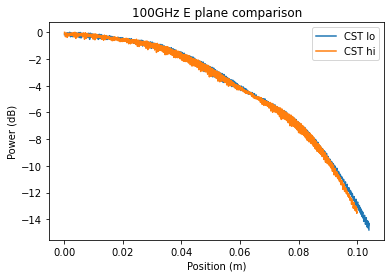

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

#Check CST Convergence
#run13 is 100GHz with mesh=[6,4;4,2]
#run35 is 100GHz with mesh=[8,5;5,3]
xpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run13/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run13/zpos.txt')
power=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run13/power.txt')
xpos2=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run35/xpos.txt')
zpos2=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run35/zpos.txt')
power2=np.loadtxt('../EXCLAIM_Optics/EXCLAIM_Data/US2run35/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100
xpos2=xpos2/100 # convert from cm to m
zpos2=zpos2/100

#fig, ax = plt.subplots()
#scaling=10*np.log10(power-power2)-max(10*np.log10(power-power2))
#c=ax.scatter(xpos,zpos,c=scaling)
#fig.colorbar(c,ax=ax)
#plt.title('CST')
#plt.xlabel('Position (m)')
#plt.ylabel('Position (m)')
#plt.savefig("CST_100GHz.png")
#plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
Epos2=np.zeros(len(xpos))
Epow2=np.zeros(len(xpos))
count=0
count2=0
zmin=min(abs(zpos))+0.001
zmin2=min(abs(zpos2))+0.001
for it in np.arange(0,len(xpos2)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]            
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
    if abs(zpos2[it])<=zmin2:
        if xpos2[it]>=0:
            Epow2[count2]=power2[it]            
            Epos2[count2]=xpos2[it]
            count2 += 1
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
Epos2=Epos2[:count2]
Epow2=10*np.log10(Epow2[:count2])
Epow2max=max(Epow2)
        
plt.plot(Epos,Epow-Epowmax,label='CST lo')
plt.plot(Epos2,Epow2-Epow2max,label='CST hi')
plt.title('100GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
#plt.savefig("Eplane_100GHz_comparison.png")
plt.show()

#plt.plot(Epos,Epow2-Epow,label='hi-lo')
#plt.title('100GHz E plane comparison')
#plt.xlabel('Position (m)')
#plt.ylabel('Power (dB)')
#plt.legend()
#plt.show()


c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'width (cm)')

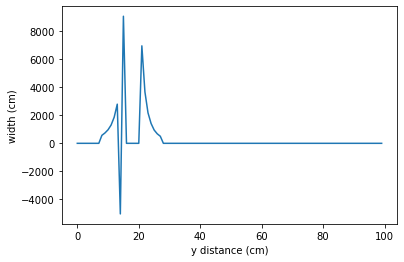

In [23]:
# This block will be used to make on-axis predictions of the beamwidth near the IF
# 2/23/2021
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import astropy.units as u
from astropy import constants as const
import poppy

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 50 * u.GHz 
    
ll = const.c/ff

wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)
   
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
wf *= lenslet_aperture

ring = poppy.CircularAperture(radius=0.0381*u.m)
wf *= ring # cold stop

wf.propagate_fresnel(d_lens_3) # propogate to center of tertiary

wf *= tertiary_obj

def Gauss(x,a,w):
    return a*np.exp(-(x/w)**2)

n=100
d=0.01*u.m
ws=np.zeros((n,1))
for it in range(0,n):
    wf.propagate_fresnel(d) 
    Eplane=wf.intensity[wf.intensity.shape[1]//2,1024:]
    y, x = wf.coordinates()
    x=x[x.shape[1]//2,1024:]
    popt,pcov = curve_fit(Gauss, x, Eplane)
    ws[it]=popt[1]

#wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary    
#wf *= secondary_obj   
#wf.propagate_fresnel(d_2_1) # propogate from secondary to primary

plt.plot(np.arange(0,100),ws)
plt.xlabel("y distance (cm)")
plt.ylabel("width (cm)")

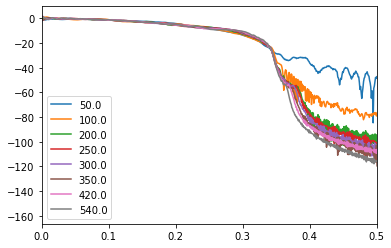

Text(0.5, 1.0, 'Primary Edge Illumination')

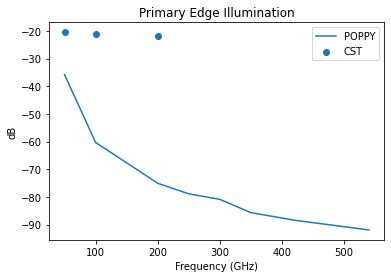

In [1]:
# Calculates POPPY's expected edge illumination at various freqs
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from astropy.units import cds

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

# Aperatures
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)
coldstop = poppy.CircularAperture(radius=0.05*u.m)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ffs = [50*u.GHz,100*u.GHz, 200*u.GHz, 250*u.GHz, 300*u.GHz, 350*u.GHz, 420*u.GHz, 540*u.GHz] # [480*u.GHz,540*u.GHz]
width=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]

illuminations = np.zeros((len(ffs),1)) # preallocate
fvals = np.zeros_like(illuminations)

freq = 0 #iterative value

plt.figure(2)
for ff in ffs: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=8.13*u.cm, wavelength=ll) # 8.13 comes from Trevor

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    wf *= coldstop

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3 - baffle_z_array[-1]) # propogate to center of tertiary

    wf *= tertiary_obj
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    #wf *= secondary_obj
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    #r = x[wf.intensity.shape[1]//2,1024:]
    r = x[y==0]
    #intensity = 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:])
    intensity = 10*np.log10(wf.intensity[y==0])
    illuminations[freq] = intensity[np.argmin(np.abs(r-0.4))]-np.max(intensity) #maybe intensity is being indexed wrong?
    
    fvals[freq] = ff.value
    
    plt.plot(r,intensity,label=str(ff.value))
    
    freq = freq + 1

plt.xlim([0,0.5])
#plt.ylim([-50,-20])
plt.legend()
plt.show()
    
plt.figure(1)    
plt.plot(fvals,illuminations,label="POPPY")
plt.scatter([50,100,200],[-20.5,-21,-22],label="CST")
plt.xlabel("Frequency (GHz)")
plt.ylabel("dB")
plt.legend()
plt.title("Primary Edge Illumination")

In [2]:
d_lens_3 - baffle_z_array[-1]

<Quantity 21.249 cm>

In [3]:
d_lens_3

<Quantity 33.06 cm>

In [4]:
baffle_z_array

[<Quantity 0.889 cm>,
 <Quantity 1.778 cm>,
 <Quantity 2.667 cm>,
 <Quantity 5.461 cm>,
 <Quantity 6.35 cm>,
 <Quantity 7.239 cm>,
 <Quantity 10.033 cm>,
 <Quantity 10.922 cm>,
 <Quantity 11.811 cm>]